# A Simulated Period in NuSTAR Data

Let's simulate a periodic signal in some heavily dead time-affected NuSTAR data.

Here are some imports:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# some plotting defaults
sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

# numerical libraries
import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from scipy.ndimage.filters import gaussian_filter1d

# Stingray classes to make light curves, cross spectra, periodograms etc
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum, AveragedPowerspectrum
from stingray.simulator.simulator import Simulator
from stingray.events import EventList
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum

# hendrics has useful functionality to simulate NuSTAR dead time
from hendrics.fake import filter_for_deadtime
from hendrics.io import load_events

# set random seed so that I can reproduce results exactly
np.random.seed(1209432)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:20: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## Simulating

Let's make a light curve with only white noise and dead time. Properties are taken to roughly match the Her X-1 example:

In [31]:
dt = 0.5/512
tstart = 0
tseg = 5000

mean_cr = 400.0

In [32]:
time = np.arange(tstart, tstart+tseg, dt)

In [33]:
# make a random set of 
toa1 = np.sort(np.random.uniform(tstart, tstart+tseg, size=int(tseg*mean_cr)))
toa2 = np.sort(np.random.uniform(tstart, tstart+tseg, size=int(tseg*mean_cr)))

toa1_d = filter_for_deadtime(toa1, 2.5e-3)
toa2_d = filter_for_deadtime(toa2, 2.5e-3)

print("The fraction of photons in the final list of TOAs 1 is " + str(len(toa1_d)/(tseg*mean_cr)))
print("The fraction of photons in the final list of TOAs 2 is " + str(len(toa1_d)/(tseg*mean_cr)))

lcA = Lightcurve.make_lightcurve(toa1_d, dt, tstart=tstart, tseg=tseg)
lcB = Lightcurve.make_lightcurve(toa2_d, dt, tstart=tstart, tseg=tseg)

lctot = lcA + lcB

cs = Crossspectrum(lcA, lcB, norm='leahy')
ps = Powerspectrum(lctot, norm='leahy')

The fraction of photons in the final list of TOAs 1 is 0.499627
The fraction of photons in the final list of TOAs 2 is 0.499627


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Let's plot the result:

In [36]:
ps.power

array([ 0.02156534,  0.86556765,  0.83747364, ...,  0.90438759,
        0.3633548 ,  1.85229253])

<IPython.core.display.Javascript object>


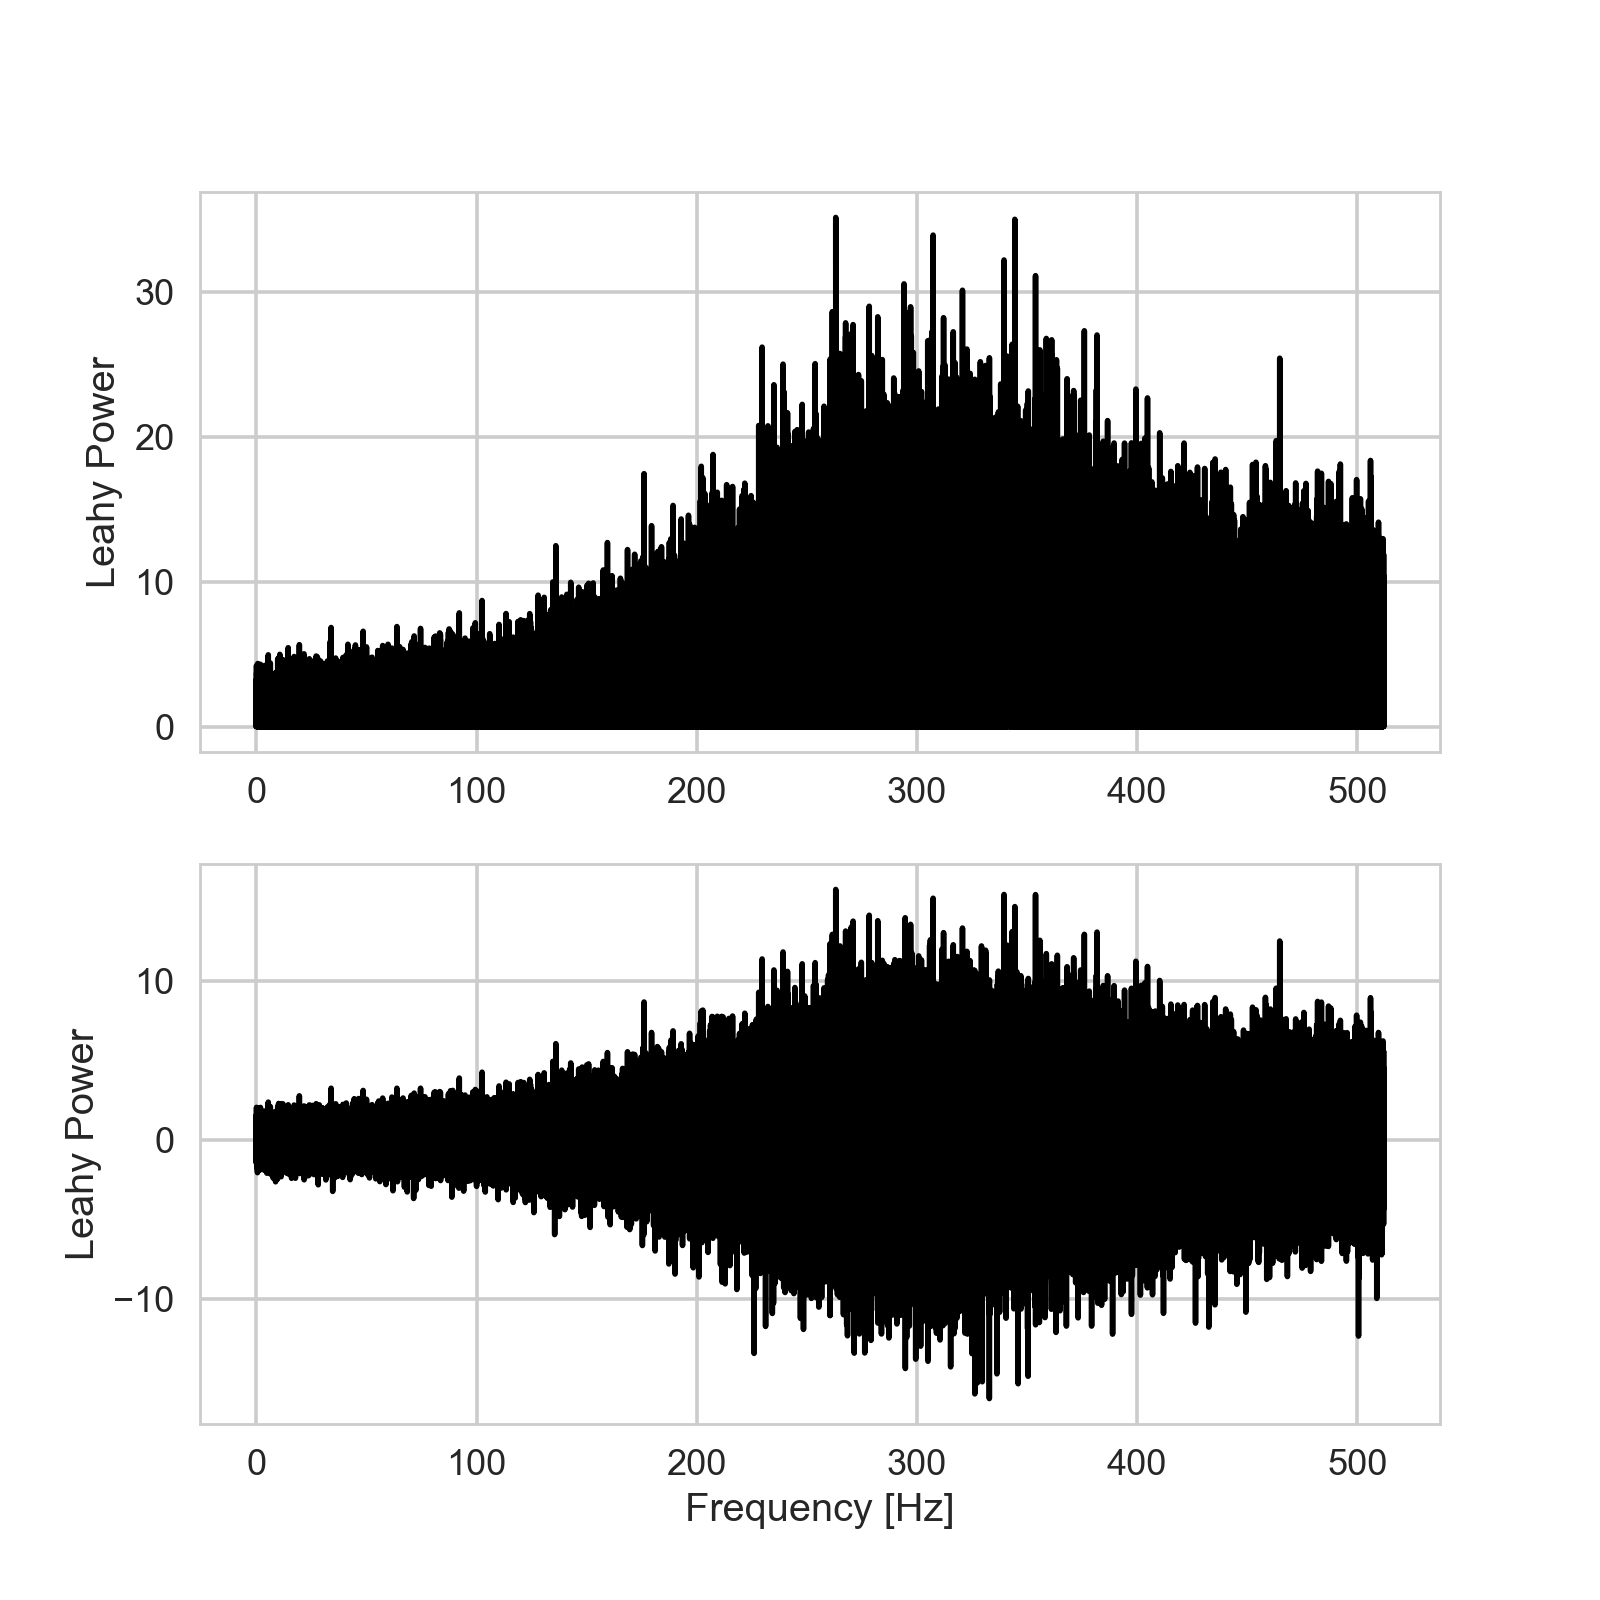

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

ax2.plot(cs.freq, cs.power, linestyle="steps-mid", lw=2, color="black")
ax1.plot(ps.freq, ps.power, linestyle="steps-mid", lw=2, color="black")

#ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")

ax1.set_ylabel("Leahy Power")
ax2.set_ylabel("Leahy Power")

Let's make some averaged periodograms and cross spectra for comparison:

In [42]:
segsize = 5.0

cs_avg = AveragedCrossspectrum(lcA, lcB, norm='leahy', segment_size=segsize)
ps_avg = AveragedPowerspectrum(lctot, norm='leahy', segment_size=segsize)


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


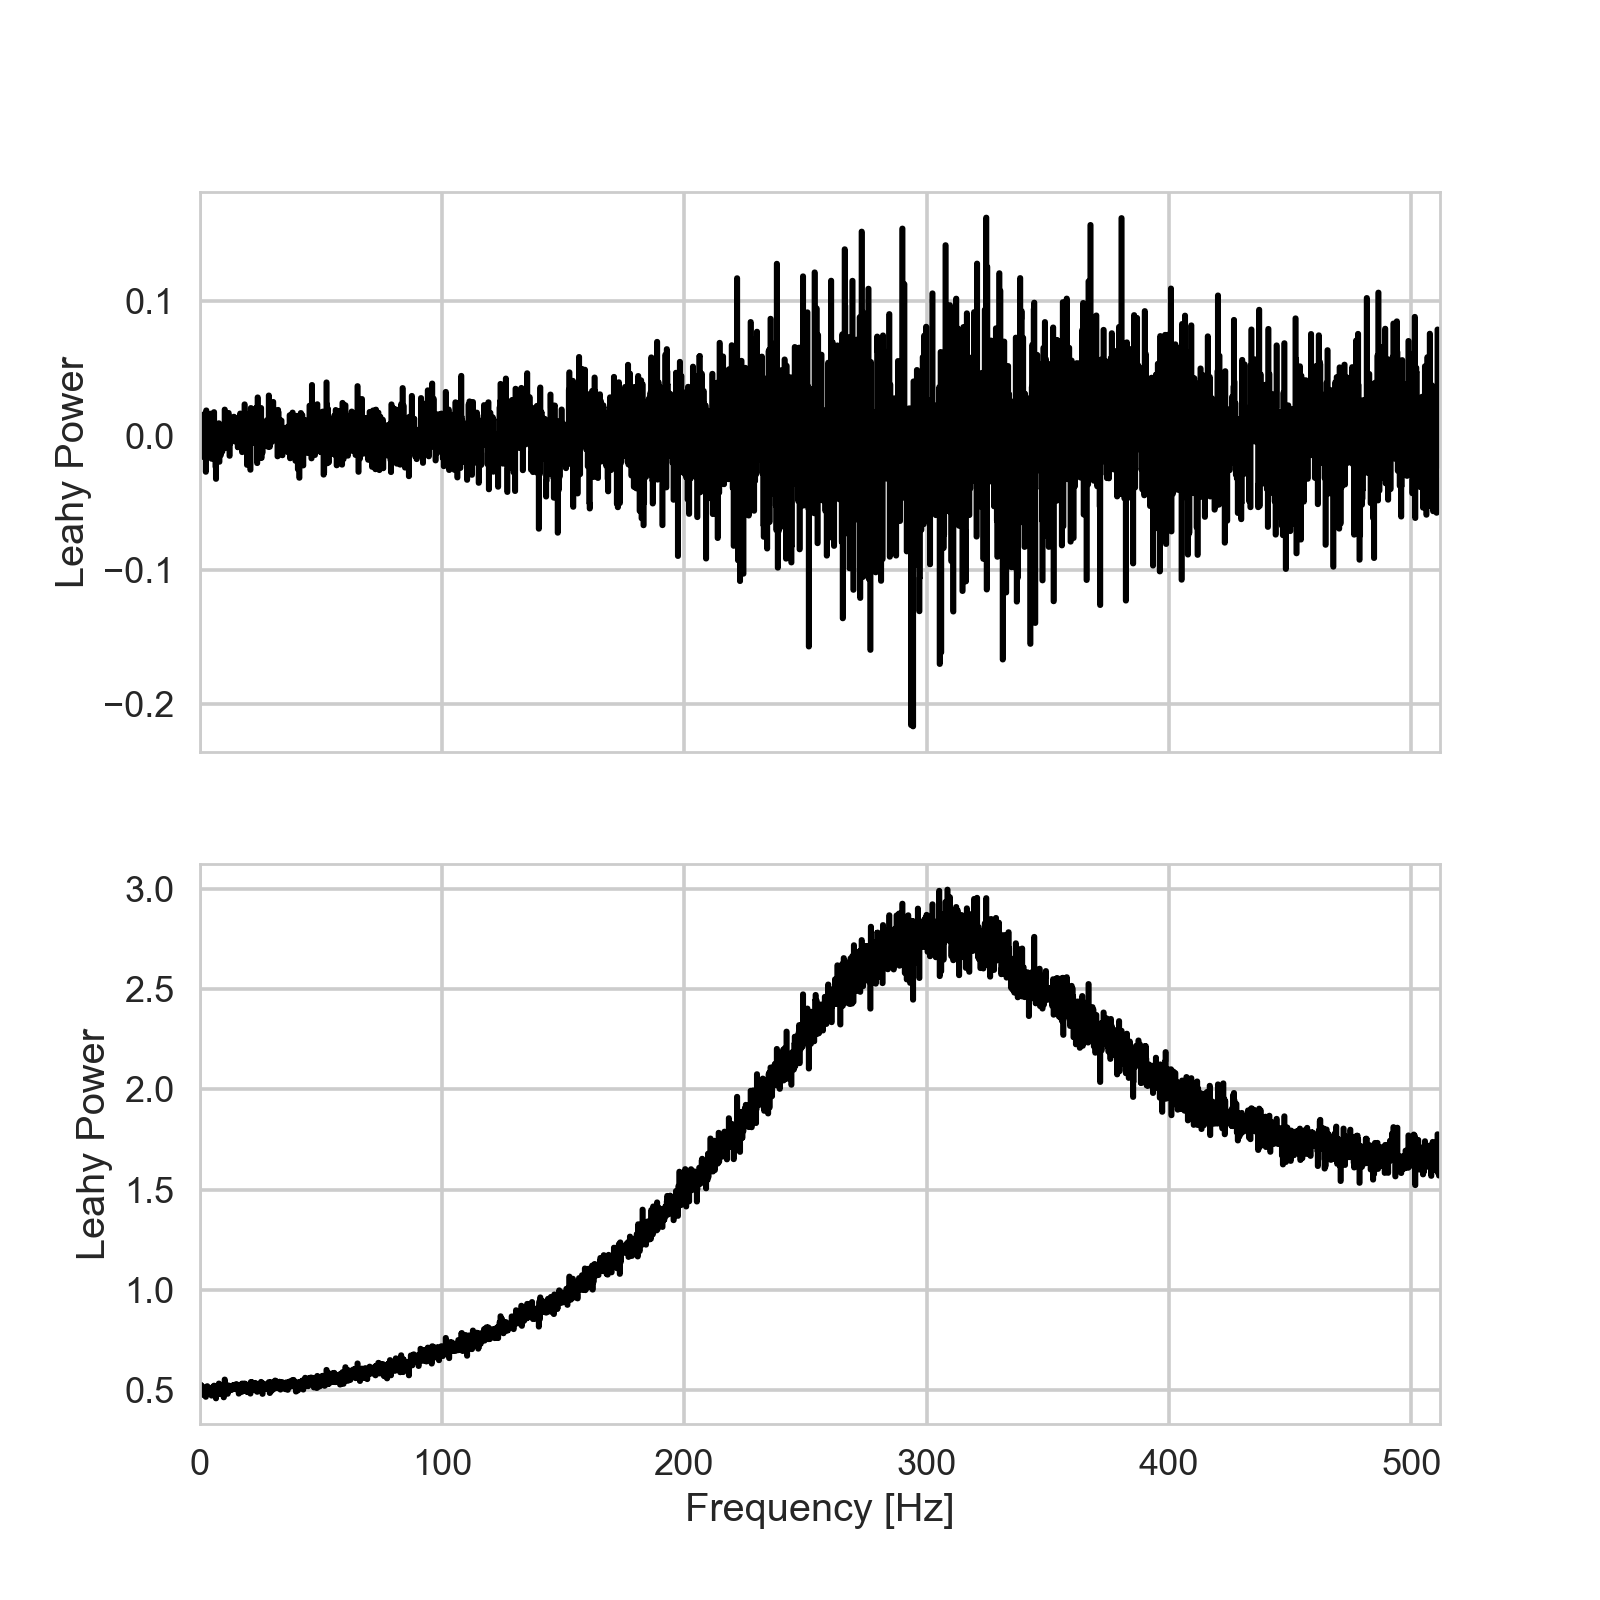

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

ax1.plot(cs_avg.freq, cs_avg.power, linestyle="steps-mid", lw=2, color="black")
ax2.plot(ps_avg.freq, ps_avg.power, linestyle="steps-mid", lw=2, color="black")

ax2.set_xlim(cs_avg.freq[0], cs_avg.freq[-1])
ax2.set_xlabel("Frequency [Hz]")

ax1.set_ylabel("Leahy Power")
ax2.set_ylabel("Leahy Power")

The power spectrum clearly shows the shifting means.

Okay, let's make lots of simulations and average them so that I can get a better handle on the changes in variance:

In [65]:
tseg = 100.0

In [166]:
nsim = 1000

cs_all, cs_nodt = [], []

ntoa1, ntoa2 = [], []

lc1_all, lc2_all = [], []

for i in range(nsim):
    toa1 = np.sort(np.random.uniform(tstart, tstart+tseg, size=int(tseg*mean_cr)))
    toa2 = np.sort(np.random.uniform(tstart, tstart+tseg, size=int(tseg*mean_cr)))

    toa1_d = filter_for_deadtime(toa1, 2.5e-3)
    toa2_d = filter_for_deadtime(toa2, 2.5e-3)

    ntoa1.append(len(toa1_d))
    ntoa2.append(len(toa2_d))
    
    lcA = Lightcurve.make_lightcurve(toa1_d, dt, tstart=tstart, tseg=tseg)
    lcB = Lightcurve.make_lightcurve(toa2_d, dt, tstart=tstart, tseg=tseg)

    lcA_nodt = Lightcurve.make_lightcurve(toa1, dt, tstart=tstart, tseg=tseg)
    lcB_nodt = Lightcurve.make_lightcurve(toa2, dt, tstart=tstart, tseg=tseg)

    lc1_all.append(lcA)
    lc2_all.append(lcB)
    
    lctot = lcA + lcB

    segsize = 10.0

    cs = AveragedCrossspectrum(lcA, lcB, norm='leahy', segment_size=segsize)
    cs_n = AveragedCrossspectrum(lcA_nodt, lcB_nodt, norm='leahy', segment_size=segsize)
    
    cs_all.append(cs.power)
    cs_nodt.append(cs_n.power)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [167]:
cs_all = np.array(cs_all)

In [168]:
cs_all.shape

(1000, 5119)

What's the fraction of photons lost due to dead time?

<IPython.core.display.Javascript object>


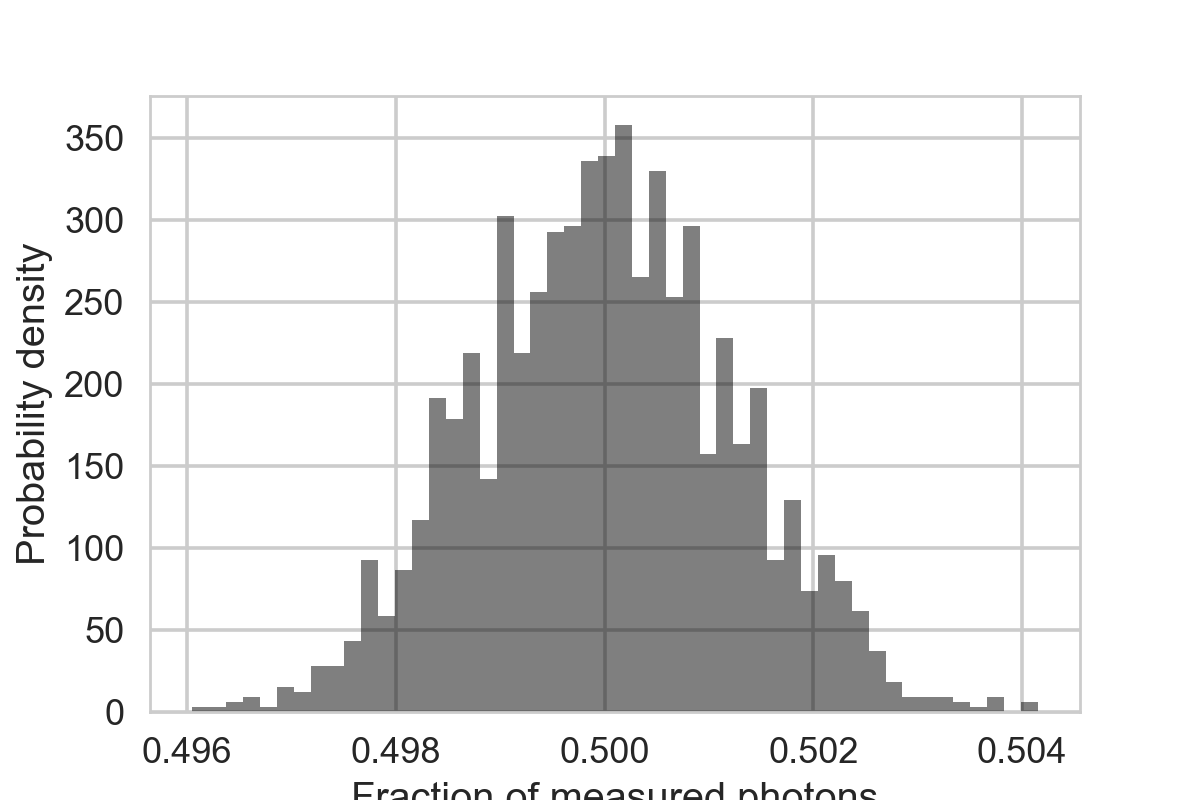

In [169]:
# expected number of photons without pile-up
toa_orig = tseg*mean_cr


fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.hstack([ntoa1, ntoa2])/toa_orig, bins=50, alpha=0.5, 
        color="black", normed=True)

ax.set_xlabel("Fraction of measured photons")
ax.set_ylabel("Probability density")


Now let's plot the distribution of cospectral densities. We're going to plot them in different frequency ranges for comparison:

In [170]:
cs.m

10

In [171]:
def averaged_cospectra_pdf(x, n):
    absnx = np.abs(n*x)
    prefac_bottom1 = scipy.special.factorial(n-1)
    prefac_bottom2 = 2.0**n
    
    numerical_prefac = n/(prefac_bottom1*prefac_bottom2)
    prefac = numerical_prefac * np.exp(-absnx)
    
    sum_all = np.zeros_like(x)
    for j in range(n):
        inside1 = n-1+j
        sum_factorial_top = scipy.special.factorial(inside1)
        
        inside2 = n - 1 - j
        sum_factorial_bottom = scipy.special.factorial(inside2)
        
        sum_factorial_bottom2 = scipy.special.factorial(j)
        sum_bin_factor = 2.0**j
        
        exponent = n - 1 - j
        
        exp_factor = absnx**exponent
        
        sum_all += (sum_factorial_top/(sum_factorial_bottom*sum_factorial_bottom2) * (exp_factor/sum_bin_factor))
        
    return sum_all*prefac

In [172]:
# Laplace distribution for cospectral densities
lapl = scipy.stats.laplace(0, 1)

# chisquare distribution for power spectral densities
chisq = scipy.stats.chi2(2)
chisq_ave2 = scipy.stats.chi2(4)

In [173]:
gauss = scipy.stats.norm(0, np.sqrt(2)/np.sqrt(100+1))

<IPython.core.display.Javascript object>


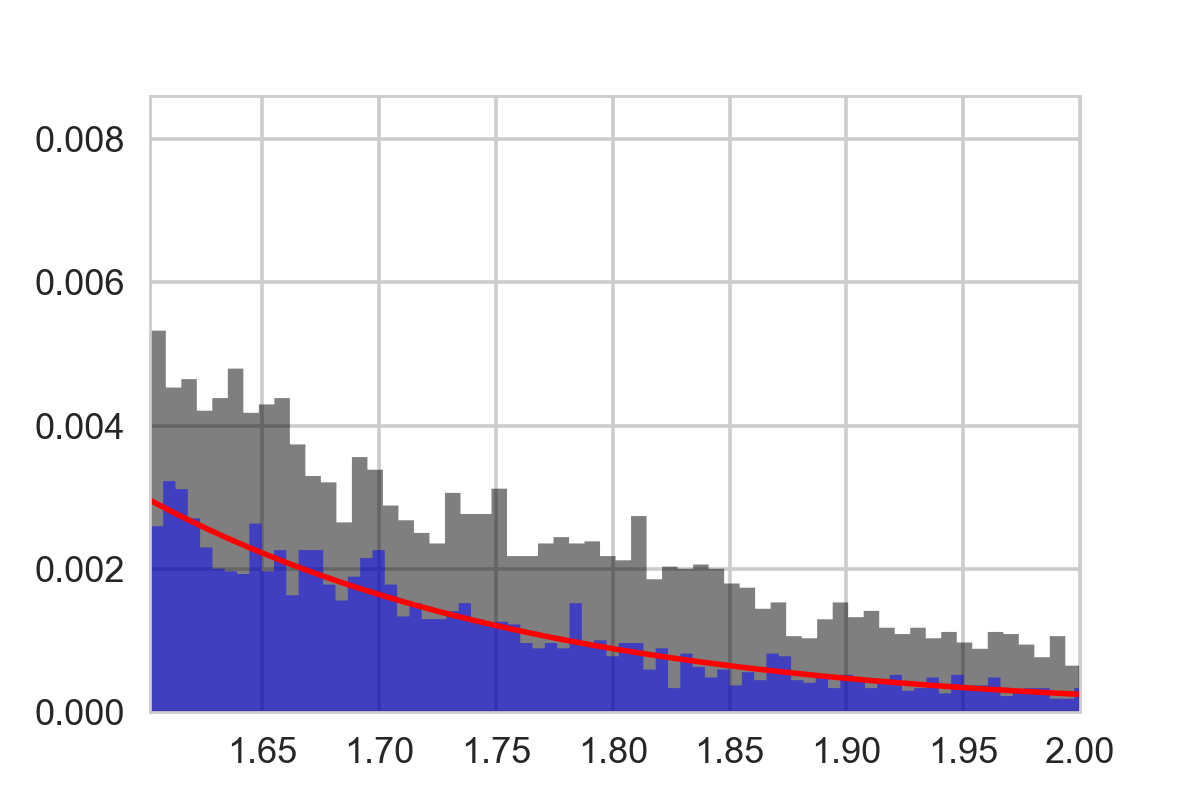

(-2, 2)

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.hstack(cs_all), bins=1000, histtype="stepfilled", 
        color="black", alpha=0.5, normed=True);
ax.hist(np.hstack(cs_nodt), bins=1000, histtype="stepfilled", 
        color="blue", alpha=0.5, normed=True);


x = np.linspace(-2, 2, 1000)
prob = averaged_cospectra_pdf(x, n=10)

ax.plot(x, prob, lw=2, color='red')
ax.set_xlim(-2, 2)

Let's compute a simple KS-test to compare the Laplace distribution:

In [76]:
mean, width = scipy.stats.laplace.fit(cs_all)

We should probably correct our simulated powers using the Fourier Amplitude Difference technique:

In [175]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from fad_correction import *

countrate_ratio = lcA.meanrate / lcB.meanrate

segment_size = 10.0

In [176]:
lc1 = lc1_all[0]
lc2 = lc2_all[0]

In [201]:
lc_tot = lc1 + lc2

In [202]:
ps_dead = AveragedPowerspectrum(lc_tot, segment_size=segment_size, norm="leahy")

In [203]:
cs_dead = AveragedCrossspectrum(lc1, lc2, segment_size=segment_size, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [204]:
res = FAD_power_spectra(lc1, lc2, segment_size)

In [205]:
cs_norm = copy.deepcopy(cs_dead)
cs_norm.norm = 'none'
cs_norm.power = res.cs
log_nphots1 = np.log(cs_dead.nphots1)
log_nphots2 = np.log(cs_dead.nphots2)

actual_nphots = np.float64(np.sqrt(np.exp(log_nphots1 + log_nphots2)))
cs_norm.power = cs_norm.power * 2. / actual_nphots



<IPython.core.display.Javascript object>


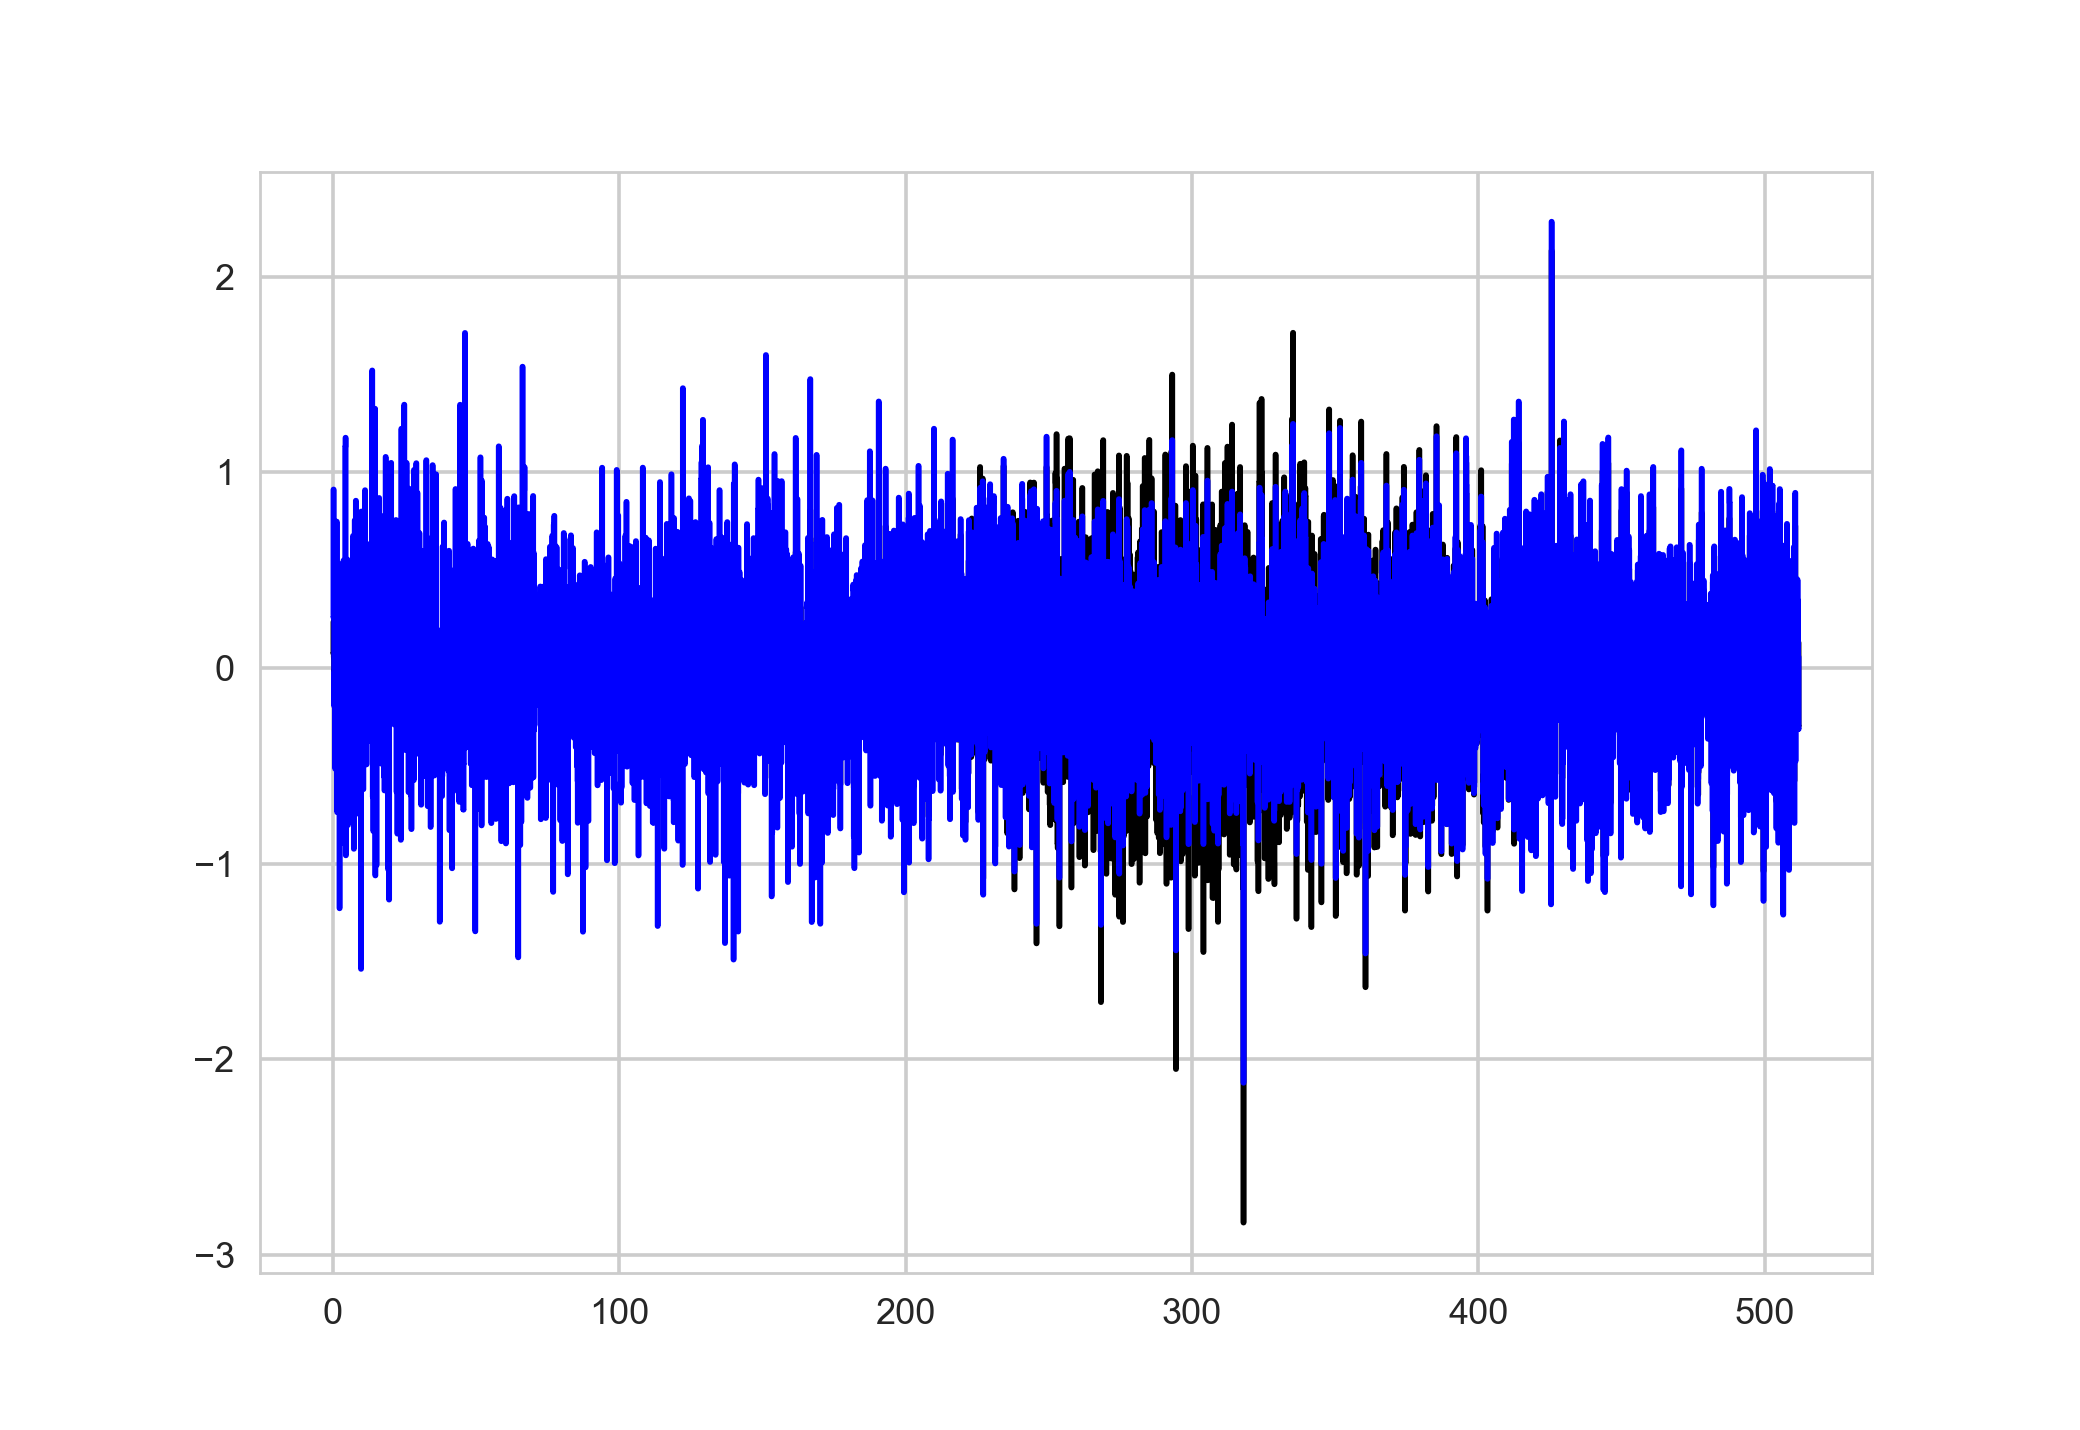

In [207]:
plt.figure()
plt.plot(cs_dead.freq, cs_dead.power, linestyle="steps-mid", lw=2, color="black")
plt.plot(cs_dead.freq, cs_norm.power, linestyle="steps-mid", lw=2, color="blue")

In [181]:

cs_dt, cs_corr = [], []

for lc1, lc2 in zip(lc1_all, lc2_all):
    cs_dead = AveragedCrossspectrum(lc1, lc2, segment_size=segment_size, norm="leahy")
    res = FAD_power_spectra(lc1, lc2, segment_size)

    cs_norm = copy.deepcopy(cs_dead)
    cs_norm.norm = 'none'
    cs_norm.power = res.cs
    
    log_nphots1 = np.log(cs_dead.nphots1)
    log_nphots2 = np.log(cs_dead.nphots2)

    actual_nphots = np.float64(np.sqrt(np.exp(log_nphots1 + log_nphots2)))
    cs_norm.power = cs_norm.power * 2. / actual_nphots
    cs_corr.append(cs_norm.power)


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Let's plot the distributions again:

In [182]:
res.cs

array([ 259.07270646,  912.38498264,  272.45000898, ..., -311.94688303,
         58.06892737, -312.69216693])

<IPython.core.display.Javascript object>


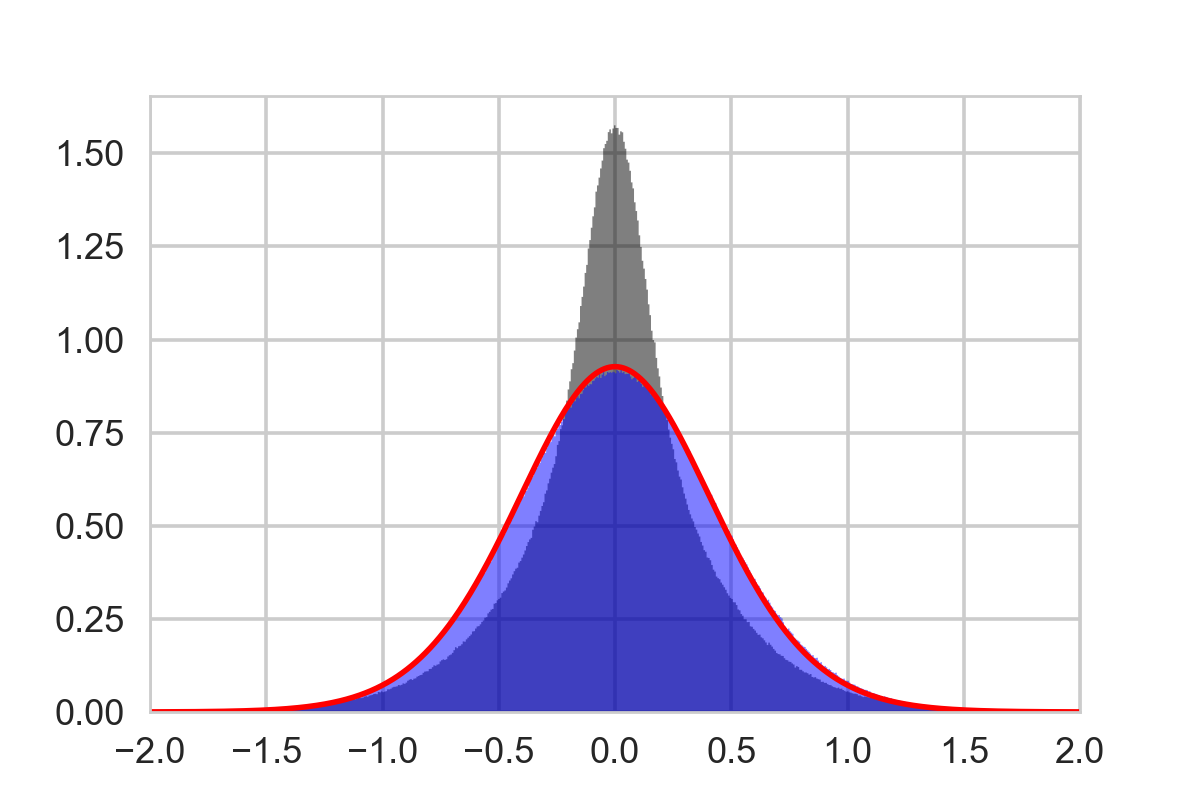

(-2, 2)

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(np.hstack(cs_all), bins=1000, histtype="stepfilled", 
        color="black", alpha=0.5, normed=True, label="dead time-affected cospectra");
ax.hist(np.hstack(cs_corr), bins=1000, histtype="stepfilled", 
        color="blue", alpha=0.5, normed=True, label="FAD-corrected cospectra");


x = np.linspace(-2, 2, 1000)
prob = averaged_cospectra_pdf(x, n=10)

ax.plot(x, prob, lw=2, color='red', label="theoretical distribution")
ax.set_xlim(-2, 2)

Let's combine that with the periodogram and cospectra:

<IPython.core.display.Javascript object>


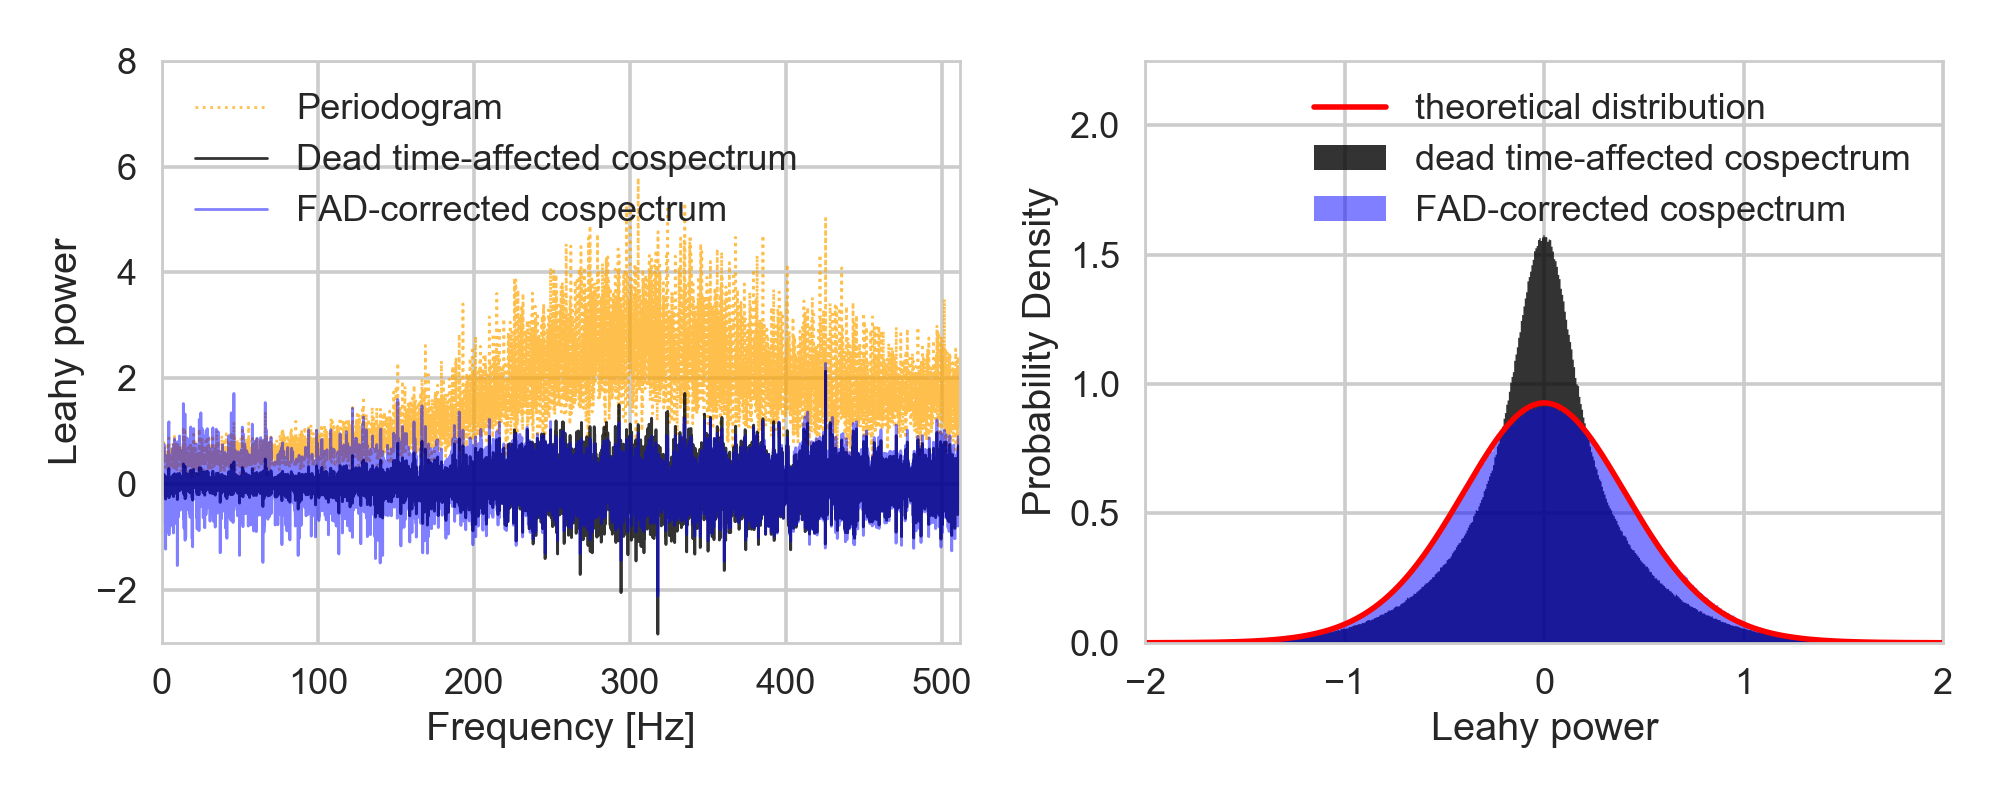

In [224]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(ps_dead.freq, ps_dead.power, linestyle="dotted", alpha=0.7, lw=1, 
         color="orange", label="Periodogram")

ax1.plot(cs_dead.freq, cs_dead.power, linestyle="steps-mid", color="black", 
         alpha=0.8, lw=1, label="Dead time-affected cospectrum")
ax1.plot(cs_dead.freq, cs_norm.power, linestyle="steps-mid", color="blue", 
         alpha=0.5, lw=1, label="FAD-corrected cospectrum")

ax1.legend()

ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy power")
ax1.set_xlim(ps_dead.freq[0], ps_dead.freq[-1])
ax1.set_ylim(-3, 8)

ax2.hist(np.hstack(cs_all), bins=1000, histtype="stepfilled", 
        color="black", alpha=0.8, normed=True, label="dead time-affected cospectrum");
ax2.hist(np.hstack(cs_corr), bins=1000, histtype="stepfilled", 
        color="blue", alpha=0.5, normed=True, label="FAD-corrected cospectrum");

ax2.set_xlabel("Leahy power")
ax2.set_ylabel("Probability Density")

x = np.linspace(-2, 2, 1000)
prob = averaged_cospectra_pdf(x, n=10)

ax2.plot(x, prob, lw=2, color='red', label="theoretical distribution")
ax2.set_xlim(-2, 2)
ax2.set_ylim(0, 2.25)

ax2.legend()

plt.tight_layout()
plt.savefig("../paper/whitenoise_deadtime.png", format="png")

In [184]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)

        for j in range(n):
            prefac_top = scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc.factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            gf = -j + n
            
            first_fac = scipy.special.gamma(gf)

            if x >= 0:    
                second_fac = scipy.special.gammaincc(gf, n*x) * first_fac
                fac = 2.0*first_fac - second_fac
            else:
                fac = scipy.special.gammaincc(gf, -n*x) * first_fac
            
            cdf[i] += (prefac * fac)
                
    return cdf
        

In [185]:
def avg_cospectra_with_n(x):
    return averaged_cospectra_cdf(x, 10)

In [186]:
cs_corr_flat = np.hstack(cs_corr)

In [199]:
scipy.stats.kstest(cs_corr_flat[:50000], avg_cospectra_with_n)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  """
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  if __name__ == '__main__':


KstestResult(statistic=0.01240212945923902, pvalue=4.178537559395251e-07)

What's the difference in p-value for the distributions?

In [188]:
cs_dt_flat = np.hstack(cs_all)

In [196]:
len(cs_dt_flat)

5119000

In [197]:
len(cs_corr_flat)

5119000

In [190]:
xval = np.linspace(-6, 6, 1000)

pval_dt = np.zeros_like(xval)
pval_corr = np.zeros_like(xval)

len_cs_dt = len(cs_dt_flat)
len_cs_corr = len(cs_corr_flat)
for i,x in enumerate(xval):
    c_dt = np.sum((cs_dt_flat > x))/len_cs_dt
    c_corr = np.sum((cs_corr_flat > x))/len_cs_corr
    
    pval_dt[i] =  c_dt
    pval_corr[i] = c_corr

In [191]:
t_dist = 1.0 - averaged_cospectra_cdf(xval, 10)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  """
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  if __name__ == '__main__':


In [194]:
len(pval_dt)

1000

In [195]:
len(pval_corr)

1000

In [198]:
np.max(cs_corr_flat)

2.8895323336022307

<IPython.core.display.Javascript object>


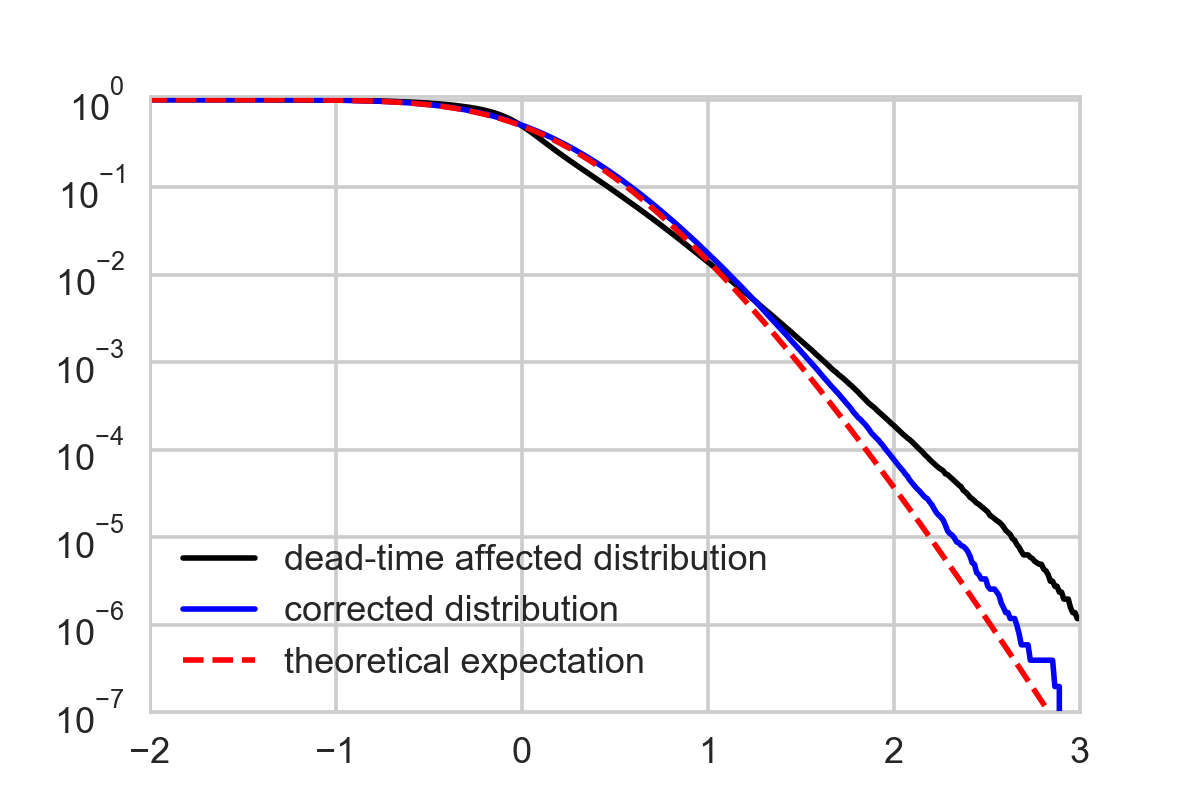

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(xval, pval_dt, lw=2, color="black", label="dead-time affected distribution")
ax.plot(xval, pval_corr, lw=2, color="blue", label="corrected distribution")
ax.plot(xval, t_dist, lw=2, color="red", label="theoretical expectation", linestyle="dashed")


ax.set_yscale("log")
ax.set_xlim(-2, 3)
ax.set_ylim(1e-7, 1.1)
ax.legend()

Even at low p-values, the difference seems to be only ~1/2 a decade.

In [4]:
cont_lc = 1 + 0.04 * np.sin(2 * np.pi * 100 * time)
cont_lc = Lightcurve(time, cont_lc, gti = [[0, 1000]])

eventsA = EventList()
eventsA.simulate_times(cont_lc)

eventsB = EventList()
eventsB.simulate_times(cont_lc)

## QPO

In [2]:
dt = 0.0005
ctrate = 200
tstop = 3000
time = np.arange(0, tstop, dt)
phase = np.cumsum(np.random.normal(0, 0.01, len(time)))
counts = (1 + 0.09 * np.sin(2 * np.pi * (200 * time + phase))) * ctrate * dt

In [3]:
time.shape

(6000000,)

In [4]:
cont_lc = Lightcurve(time, counts, gti = [[0, tstop]], err_dist='gauss')

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [5]:
1/200

0.005

In [6]:
eventsA = EventList()
eventsA.simulate_times(cont_lc)

eventsB = EventList()
eventsB.simulate_times(cont_lc)

In [7]:
eventsA

<IPython.core.display.Javascript object>


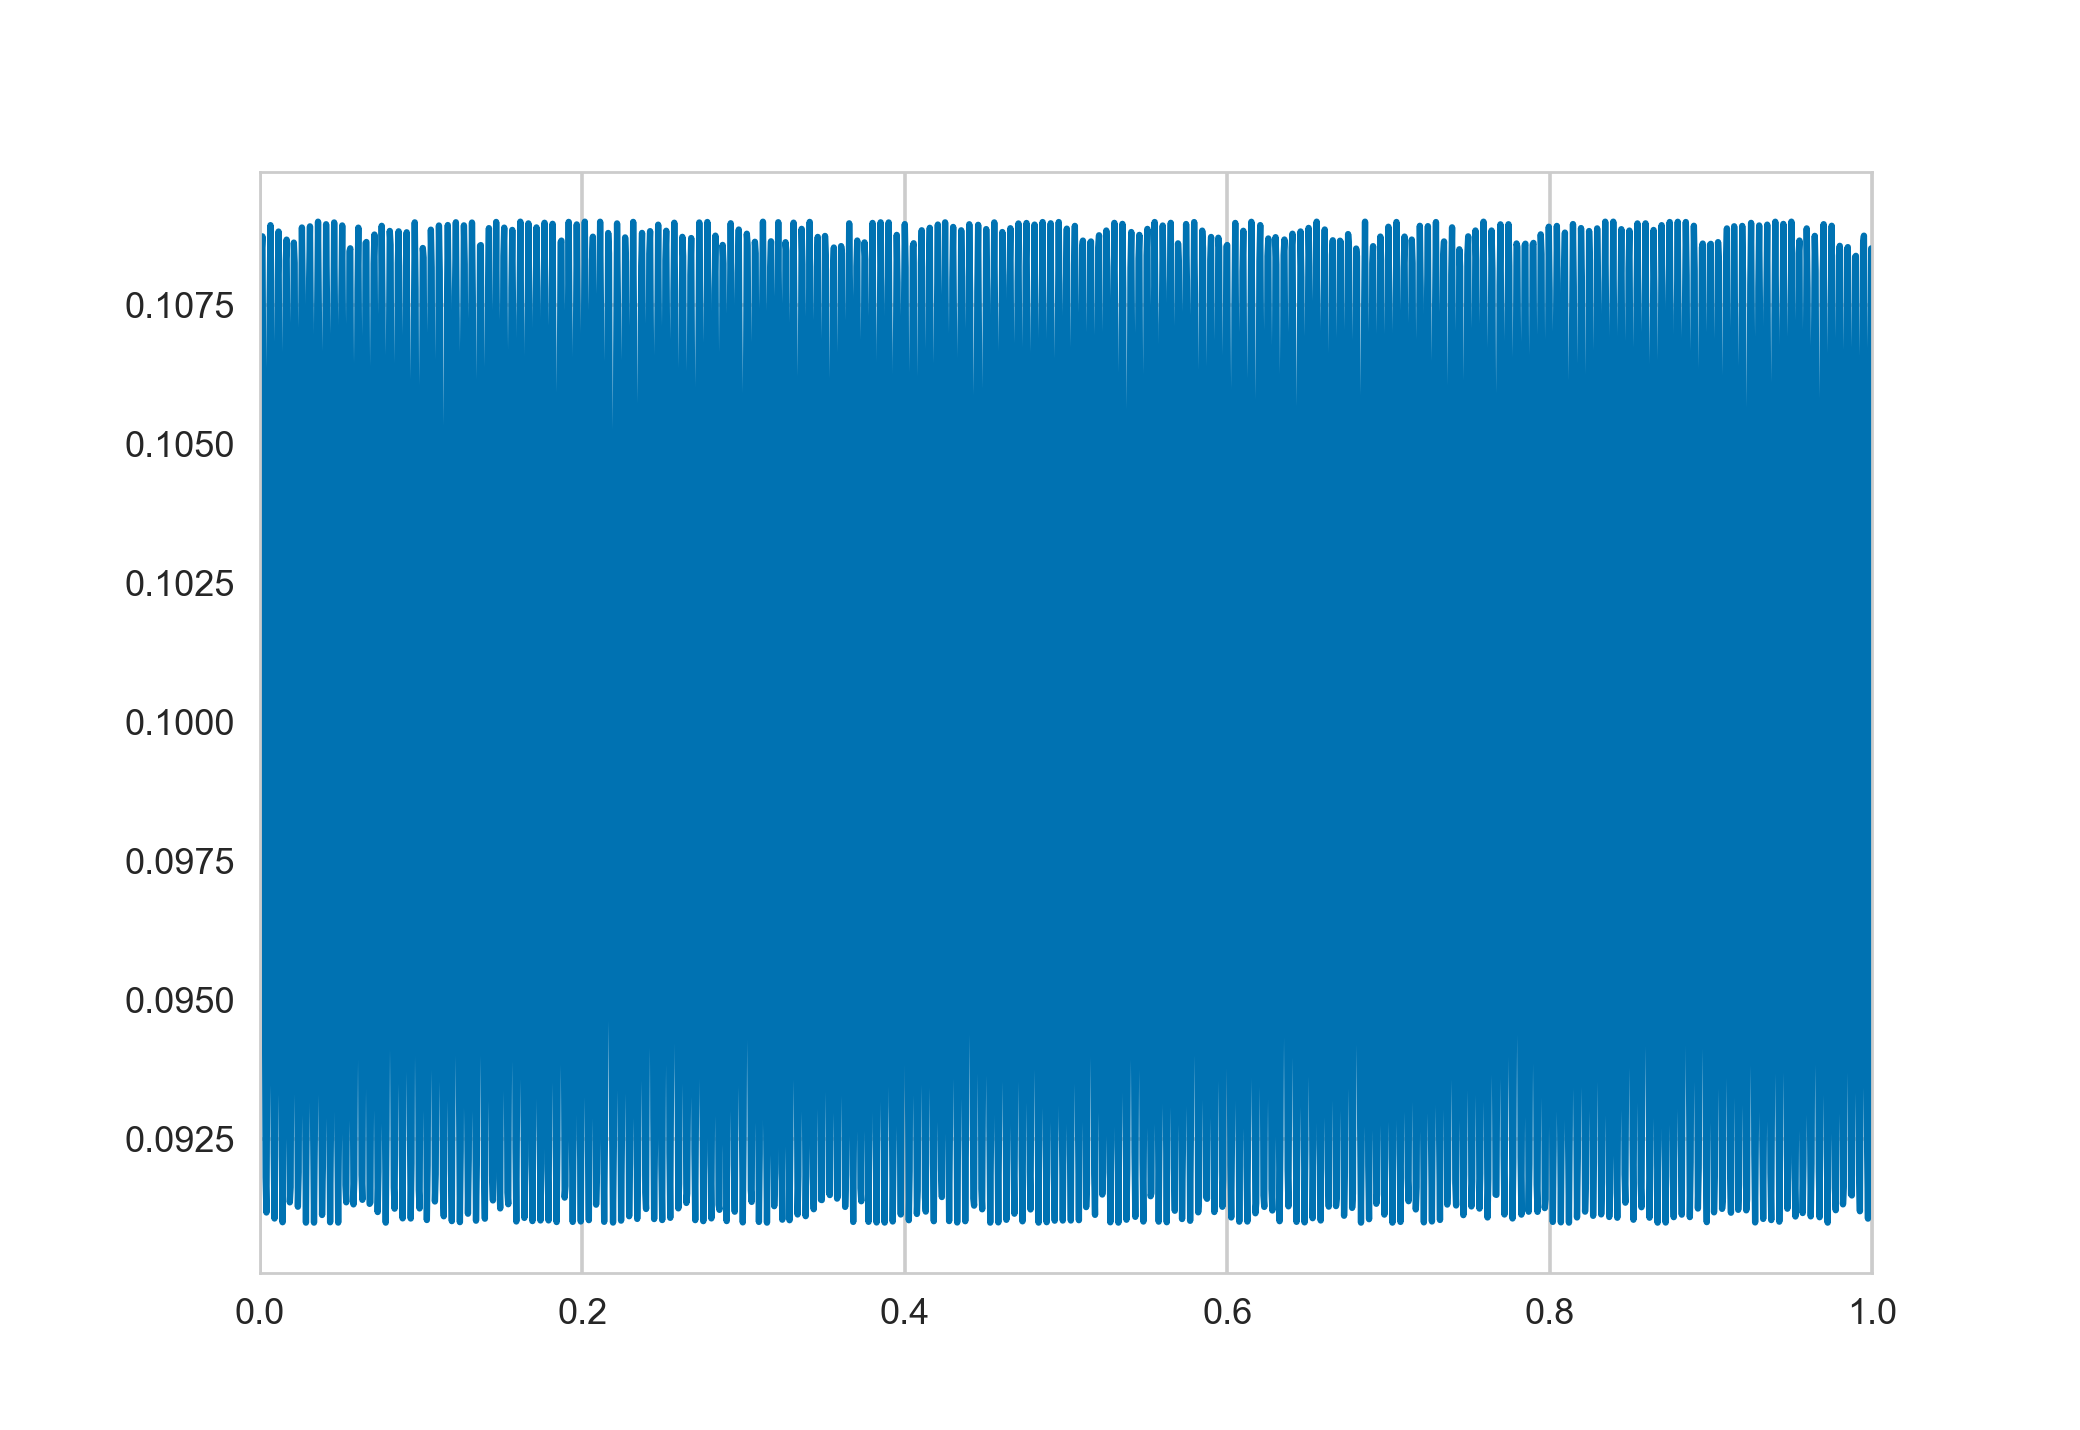

(0, 1)

In [8]:
plt.figure()
plt.plot(time, counts)
plt.xlim([0, 1])

In [9]:
import copy
eventsA_dt = copy.deepcopy(eventsA)
eventsA_dt.time = filter_for_deadtime(eventsA.time, 2.5e-3)
eventsB_dt = copy.deepcopy(eventsB)
eventsB_dt.time = filter_for_deadtime(eventsB.time, 2.5e-3)

In [10]:
lcA = eventsA_dt.to_lc(dt)
lcB = eventsB_dt.to_lc(dt)
lctot = lcA + lcB

In [16]:
segsize = 5.0

In [17]:
cs = AveragedCrossspectrum(lcA, lcB, norm='leahy', segment_size=segsize)
psa = AveragedPowerspectrum(lcA, norm='leahy', segment_size=segsize)
psb = AveragedPowerspectrum(lcB, norm='leahy', segment_size=segsize)
pstot = AveragedPowerspectrum(lctot, norm='leahy', segment_size=segsize)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [18]:
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from fad_correction import *


In [20]:

countrate_ratio = lcA.meanrate / lcB.meanrate

res = FAD_power_spectra(lcA, lcB, segsize)

cs_norm = copy.deepcopy(cs)
cs_norm.norm = 'none'
cs_norm.power = res.cs
log_nphots1 = np.log(cs.nphots1)
log_nphots2 = np.log(cs.nphots2)

actual_nphots = np.float64(np.sqrt(np.exp(log_nphots1 + log_nphots2)))
cs_norm.power = cs_norm.power * 2. / actual_nphots


In [21]:
chisq = scipy.stats.chi2(2*600, scale=1.0/(600))
chisq_ave = scipy.stats.chi2(2*2*600, scale=1.0/(2*600))

In [22]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)
        #print("x: " + str(x))
        for j in range(n):
            #print("j: " + str(j))
            prefac_top = scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc.factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            #print("prefac: " + str(prefac))
            gf = -j + n
            
            #print("gamma_fac: " + str(gf))
            first_fac = scipy.special.gamma(gf)
            #print("first_fac: " + str(first_fac))
            if x >= 0:    
                second_fac = scipy.special.gammaincc(gf, n*x) * first_fac
                #print("second_fac: " + str(second_fac))
                fac = 2.0*first_fac - second_fac
            else:
                fac = scipy.special.gammaincc(gf, -n*x) * first_fac
            
            #print("fac: " + str(fac))
            #print("prefac * fac: " + str(prefac*fac) + "\n")
            cdf[i] += (prefac * fac)
                
    return cdf
        

In [23]:
gauss = scipy.stats.norm(0, np.sqrt(2)/np.sqrt(600))

<IPython.core.display.Javascript object>


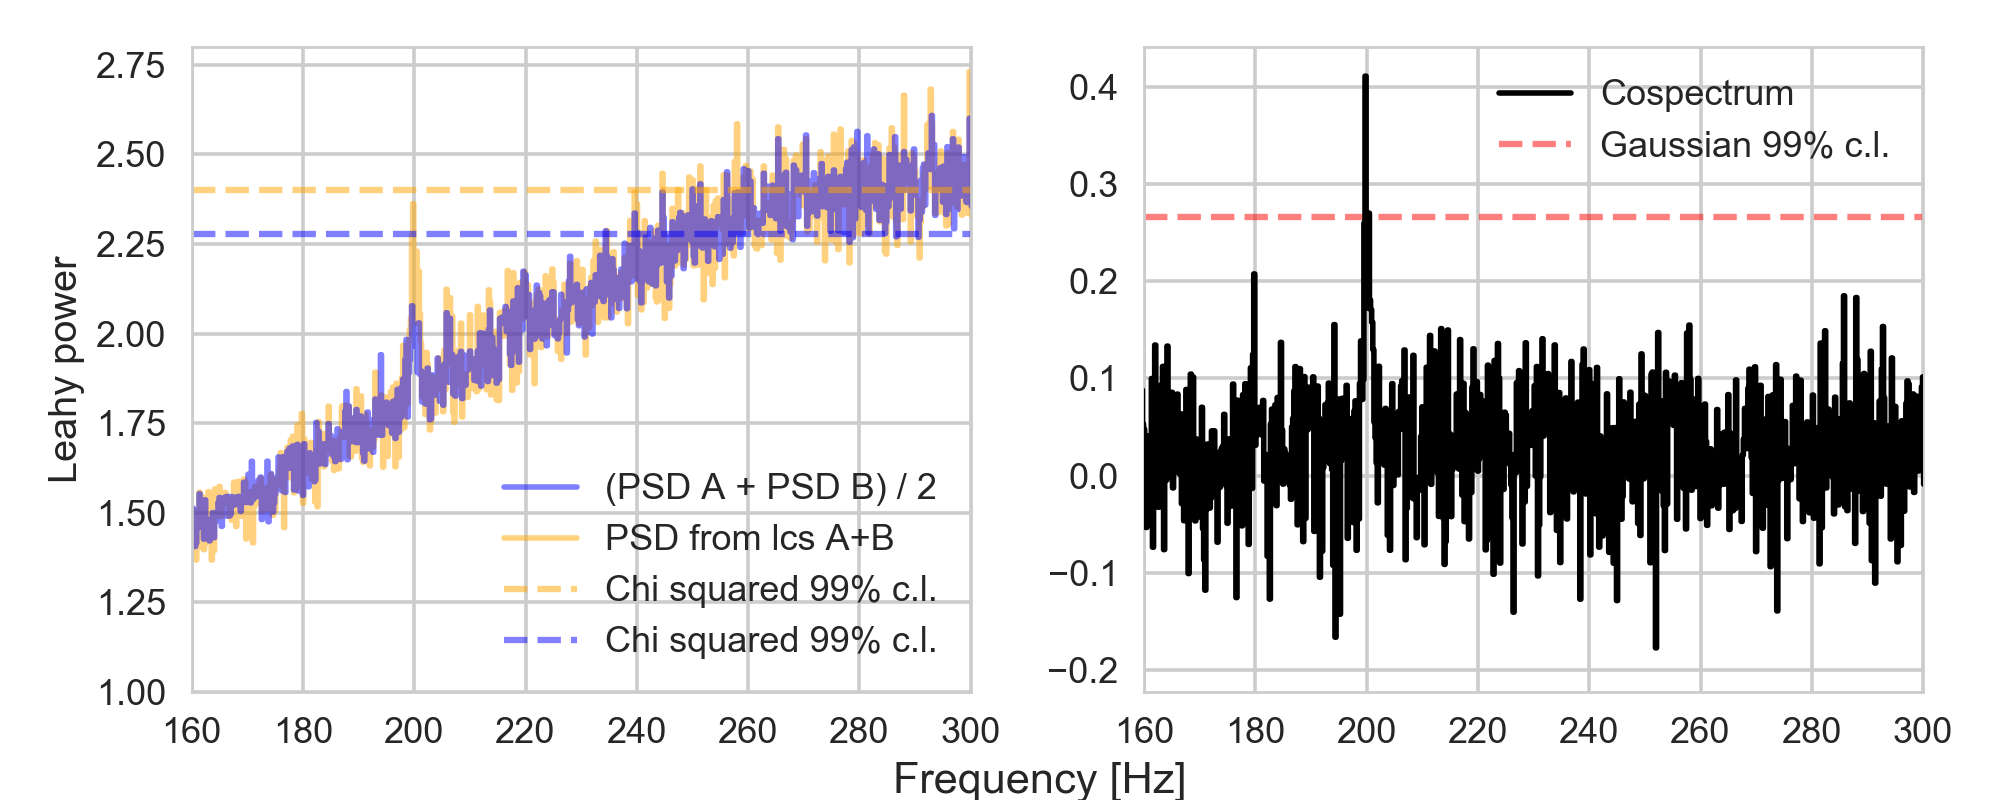

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax2.plot(cs_norm.freq, cs_norm.power, zorder=3, lw=2, color='black', label='Cospectrum', drawstyle='steps-mid')
# plt.plot(psa.freq, psa.power - 2, zorder=2, color='b', label='PDS, channel A', alpha=0.5, drawstyle='steps-mid', lw=1)
psabpower = (psa.power + psb.power)/2
ax1.plot(psa.freq, psabpower, zorder=2, color='blue', label='(PSD A + PSD B) / 2', alpha=0.5, 
         drawstyle='steps-mid', lw=2)

ax1.plot(pstot.freq, pstot.power, zorder=1, color='orange', alpha=0.5, 
         label='PSD from lcs A+B', linestyle='steps-mid', lw=2)

# plt.plot(psb.freq, psb.power, alpha=0.5, label='PDS B')
ax1.axhline(chisq.isf(0.01/len(psa.freq)), label='Chi squared 99% c.l.', color='orange', alpha=0.5, ls='--')
ax1.axhline(chisq_ave.isf(0.01/len(psa.freq)), label='Chi squared 99% c.l.', color='blue', alpha=0.5, ls='--')

ax2.axhline(gauss.isf(0.01/len(psa.freq)), label='Gaussian 99% c.l.', color='r', alpha=0.5, ls='--')



fig.text(0.52, 0.01, 'Frequency [Hz]', ha='center')

ax1.set_ylabel('Leahy power')
ax1.set_xlim([160, 300])
ax1.set_ylim(1.0, 2.8)
ax2.set_xlim([160, 300])
#plt.ylim([-0.5, 1.1])
ax1.legend()
ax2.legend()
# plt.gca().set_yscale('log', nonposy='clip')

plt.tight_layout()

plt.savefig('qpo.png')

